Gauge Comparison

/tmp/ipykernel_2743370/2120792007.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gauge_dat['205'][773:] = np.nan


/mnt/data/nragu/Tsunami/Tohoku/_results/_output6hrs/FUJI2011_42/gauge00205.txt
/mnt/data/nragu/Tsunami/Tohoku/_results/_output6hrs/FUJI2011_42/gauge00801.txt
/mnt/data/nragu/Tsunami/Tohoku/_results/_output6hrs/FUJI2011_42/gauge00802.txt
/mnt/data/nragu/Tsunami/Tohoku/_results/_output6hrs/FUJI2011_42/gauge00803.txt
/mnt/data/nragu/Tsunami/Tohoku/_results/_output6hrs/FUJI2011_42/gauge00804.txt
/mnt/data/nragu/Tsunami/Tohoku/_results/_output6hrs/FUJI2011_42/gauge00806.txt


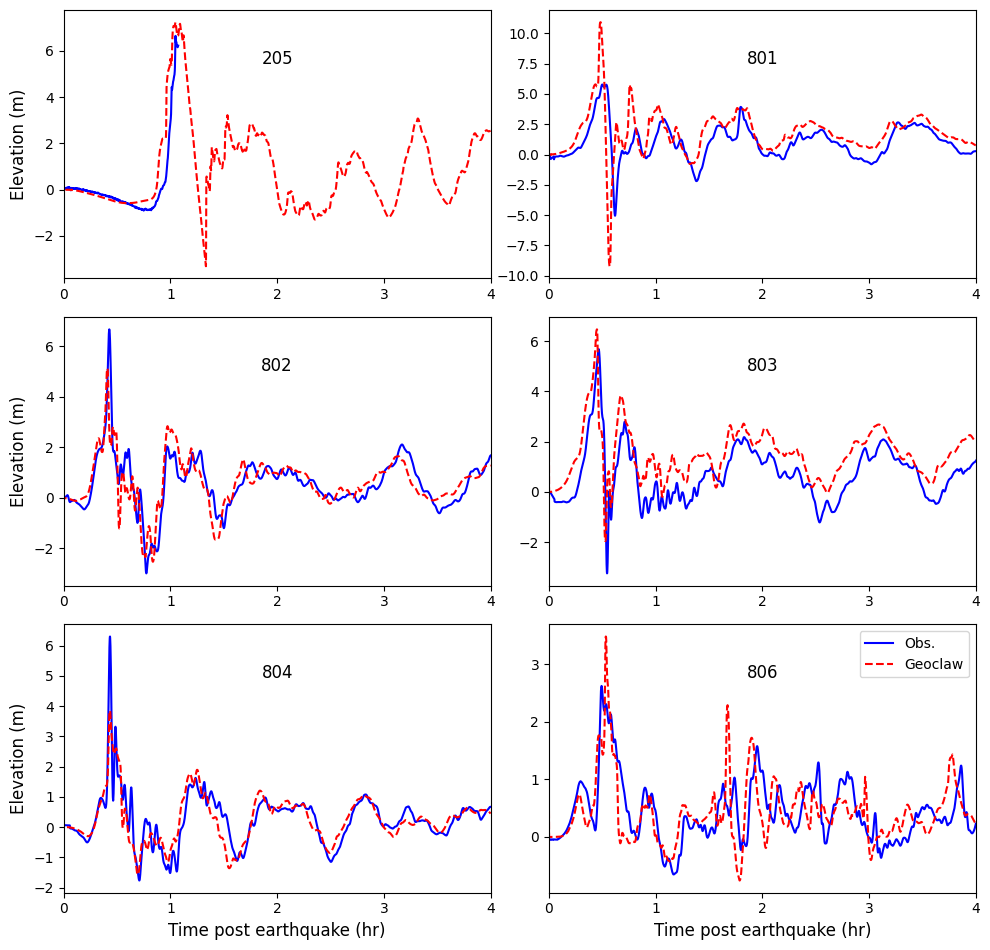

In [41]:
import geopandas as gpd
import numpy as np
import pygmt
import pandas as pd
import matplotlib.pyplot as plt

#load gauge data
gauge_file = '/mnt/data/nragu/Tsunami/Tohoku/gis/2011/Formatted/JMA_205_801_806.txt'
columns = ['time', '205', '801', '802', '803', '804', '806']
gauge_dat = pd.read_csv(gauge_file,sep='\s+',header=None)
gauge_dat.columns = columns
gauge_dat['205'][773:] = np.nan 

#read gague files
gauge_fmt = '/mnt/data/nragu/Tsunami/Tohoku/_results/_output6hrs/FUJI2011_42/gauge00{}.txt'
gauges = ['205', '801', '802', '803', '804', '806']

#read model data and save to common table
model_dat = pd.DataFrame()
for g in gauges:
    print(gauge_fmt.format(g))

    #read files
    dat = pd.read_csv(gauge_fmt.format(g),sep='\s+',header=None,skiprows=3)
    dat.columns = ['level', 'time', 'd', 'u', 'v', 'h']
    #offset in h first and second element
    # offset = -dat['h'][180] 
    offset = -dat['h'][1] 

    #add h to common table with constant offset
    model_dat[g] = dat['h'][:] + offset
    #set to nan
    # model_dat['205'][1959:] = np.nan

#add time to common table
model_dat['time'] = dat['time']

# Create a 3 by 2 grid of subplots
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

# Flatten the 3 by 2 grid into a 1D array for easier iteration
ax = ax.flatten()
for i, g in enumerate(gauges):
    ax[i].plot(gauge_dat['time'], gauge_dat[g], label='Obs.', linestyle='-', color='blue')
    ax[i].plot(model_dat['time'], model_dat[g], label='Geoclaw', linestyle='--', color='red')
    ax[i].set_xlim([0, 3600*4])
    #convert time to hours from seconds
    ax[i].set_xticks(np.arange(0, 3600*5, 3600))
    ax[i].set_xticklabels(np.arange(0, 5, 1))

    if i == 4 or i == 5:
        ax[i].set_xlabel('Time post earthquake (hr)', fontsize=12)
    if i == 0 or i == 2 or i == 4:
        ax[i].set_ylabel('Elevation (m)', fontsize=12)

    # add gague number at top middle of plot
    ax[i].text(0.5, 0.8, g, horizontalalignment='center', transform=ax[i].transAxes,fontsize=12)

# add legend
ax[i].legend(loc='upper right', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('/mnt/data/nragu/Tsunami/ML_Tohoku/Paper/_plot/gauge_comparison.png', dpi=600)

# Show the plot
plt.show()

Test Sites

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)


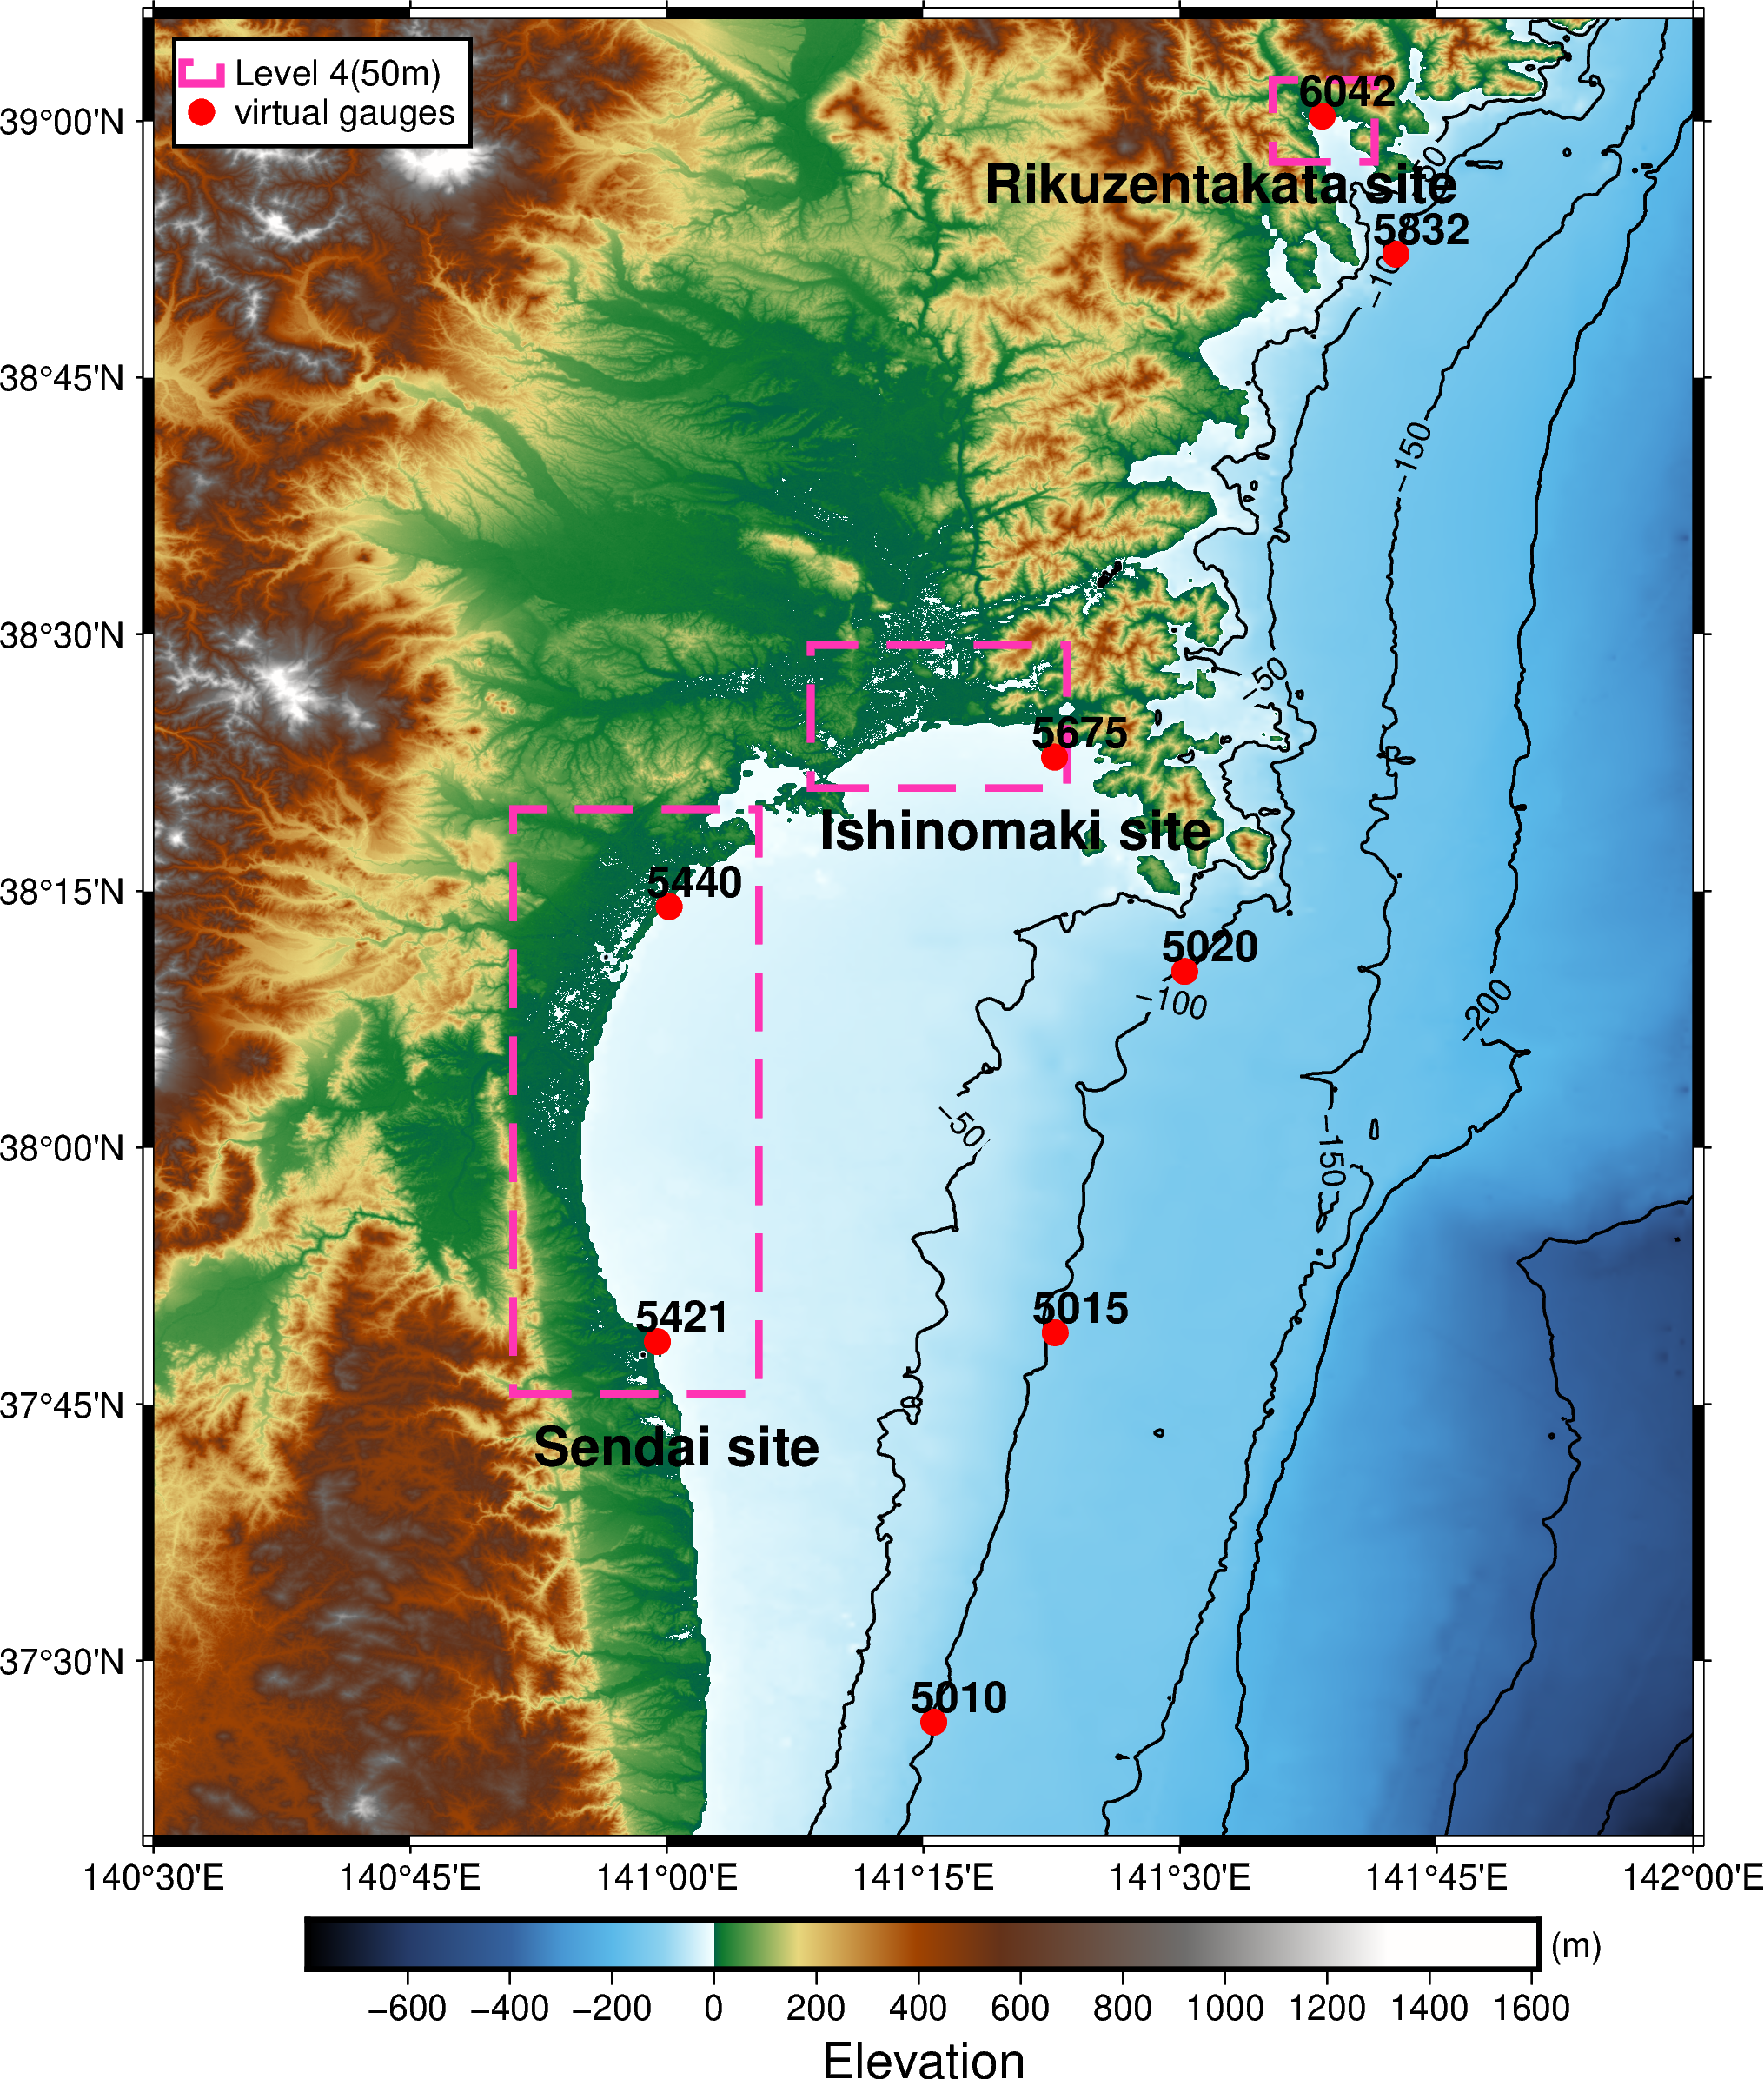

In [1]:
import geopandas as gpd
import numpy as np
import pygmt
import pandas as pd

# Load the elevation grid
grid = pygmt.datasets.load_earth_relief(resolution="03s",region=[140.5,142,37.33,39.1])

#geoclaw model domain extent
domain = gpd.read_file("/mnt/data/nragu/Tsunami/Tohoku/gis/geoclaw/fine_domain.gpkg")

#gauge locations
gagues = gpd.read_file("/mnt/data/nragu/Tsunami/Tohoku/gis/geoclaw/gauges.gpkg")
codelist = [5832,5010,5015,5020,6042,5675,5440,5421]
sel_gauges = gagues[gagues.Code.isin(codelist)]

#plot them
fig = pygmt.Figure()
fig.grdimage(grid=grid, projection="x10c/10c", frame="a", cmap="geo")
fig.grdcontour(grid=grid, interval=200,limit=[-800, -200],annotation="200+f9p,black")
fig.grdcontour(grid=grid, interval=50,limit=[-200, -50],annotation="50+f9p,black")

fig.plot(data=domain, pen="2p,maroon1,-", close=True,label="Level 4(50m)")

fig.plot(data= sel_gauges,
        style="c0.25c", 
        color="red", 
        pen="red", 
        label="virtual gauges")


#add annotations for gauges
for i in range(len(sel_gauges)):
    fig.text(
        x=sel_gauges['Longitude'].iloc[i],
        y=sel_gauges['Latitude'].iloc[i],
        text=sel_gauges['Code'].iloc[i],
        font="12p,Helvetica-Bold,black",
        justify="CM",
        offset="0.25c",
    )


fig.text(
    x=141.53,    
    y=38.93,
    text="Rikuzentakata site",
    font="15p,Helvetica-Bold,black",
    justify="CM",
    offset="0.1c",
)

fig.text(
    x=141.33,    
    y=38.3,
    text="Ishinomaki site",
    font="15p,Helvetica-Bold,black",
    justify="CM",
    offset="0.1c",
)

fig.text(
    x=141,    
    y=37.7,
    text="Sendai site",
    font="15p,Helvetica-Bold,black",
    justify="CM",
    offset="0.1c",
)

fig.colorbar(frame=["200", "x+lElevation", "y+l(m)"])
fig.legend(position="JTL+jTL+o0.2c", box='+gwhite+p1p')
fig.savefig("_plot/test_site.png")
fig.show()


Preprocessing data

/mnt/data/nragu/Tsunami/Tohoku/_results/_output_SLAB/SL_0270/gauge05832.txt
1828.9690192
/mnt/data/nragu/Tsunami/Tohoku/_results/_output_SLAB/SL_0270/gauge06042.txt
/mnt/data/nragu/Tsunami/Tohoku/_results/_output6hrs/FUJI2011_42/gauge05832.txt
680.0785557
/mnt/data/nragu/Tsunami/Tohoku/_results/_output6hrs/FUJI2011_42/gauge06042.txt


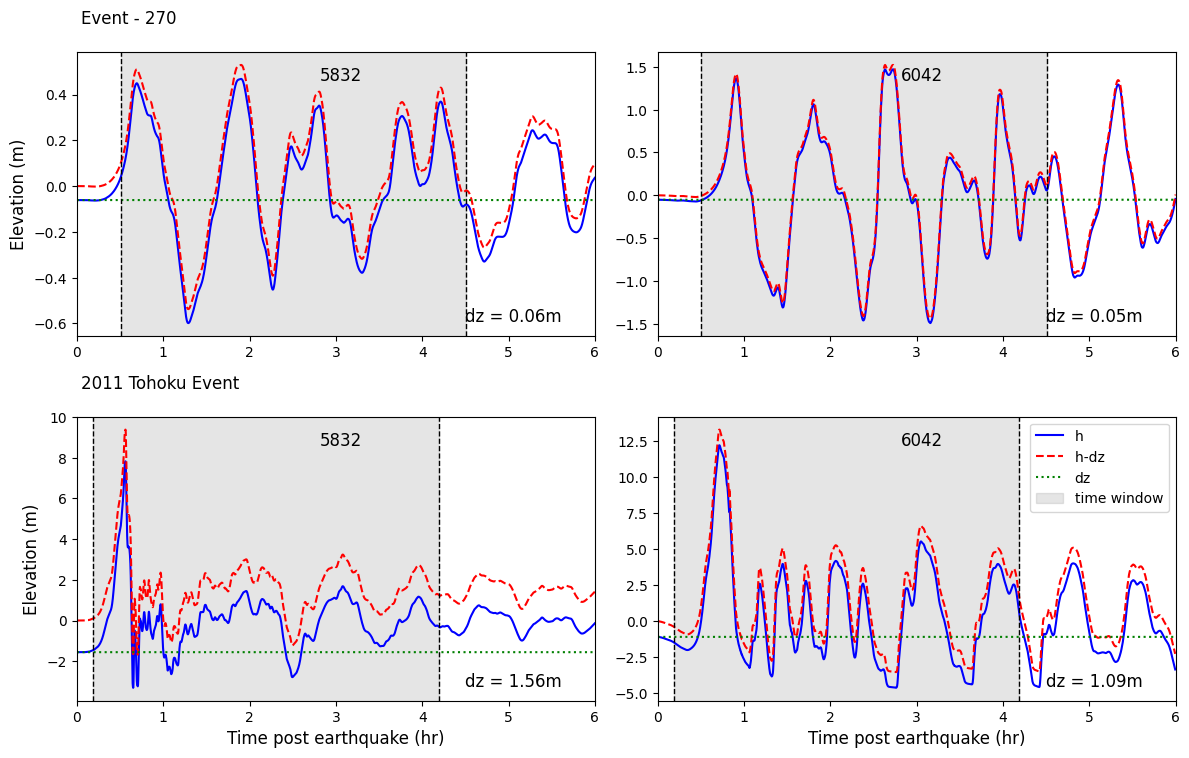

In [39]:
import geopandas as gpd
import numpy as np
import pygmt
import pandas as pd
import matplotlib.pyplot as plt

# Create a 3 by 2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

#read gague files
gauge_fmt1 = '/mnt/data/nragu/Tsunami/Tohoku/_results/_output_SLAB/SL_0270/gauge0{}.txt' #synthetic
gauge_fmt2 = '/mnt/data/nragu/Tsunami/Tohoku/_results/_output6hrs/FUJI2011_42/gauge0{}.txt' #historical

gauges = ['5832', '6042']

for i,gauge_fmt in enumerate([gauge_fmt1, gauge_fmt2]):
    #read model data and save to common table
    model_dat = pd.DataFrame()
    gauge_dat = pd.DataFrame()

    for j, g in enumerate(gauges):
        print(gauge_fmt.format(g))
        #read files
        dat = pd.read_csv(gauge_fmt.format(g),sep='\s+',header=None,skiprows=3)
        dat.columns = ['level', 'time', 'd', 'u', 'v', 'h']
        #add time to common table
        model_dat['time'] = dat['time']
        gauge_dat['time'] = dat['time']
    
        #offset in h first and second element
        # offset = -dat['h'][180] 
        offset = -dat['h'][1] 

        #add h to common table with constant offset
        model_dat[g] = dat['h'][2:] + offset
        gauge_dat[g] = dat['h'][2:]

        if j == 0 : #check gauge 5832, start time is when threshold is reached for 0.1m
            t0 = model_dat['time'][np.abs(model_dat[g]) > 0.1].iloc[0]
            print(t0)

        ax[i,j].plot(gauge_dat['time'], gauge_dat[g], label='h', linestyle='-', color='blue')
        ax[i,j].plot(model_dat['time'], model_dat[g], label='h-dz ', linestyle='--', color='red')
        
        #plot offset
        ax[i,j].plot(model_dat['time'],  gauge_dat[g] - model_dat[g], label='dz', linestyle='dotted', color='green')
        ax[i,j].set_xlim([0, 21600])
        
        #annotate the offset
        ax[i,j].annotate('dz = {:.2f}m'.format(offset), xy=(0.75, 0.05), xycoords='axes fraction', fontsize=12)

        #plot start time as vertical line
        ax[i,j].axvline(x=t0, color='black', linestyle='--', linewidth=1)

        #plot end time which is 4 hours after start time
        ax[i,j].axvline(x=t0+14400, color='black', linestyle='--', linewidth=1)
     
        #plot start and end time as a prediction window
        ax[i,j].axvspan(t0, t0+14400, alpha=0.2, color='grey', label='time window')

        #convert time to hours from seconds
        ax[i,j].set_xticks(np.arange(0, 7*3600, 3600))
        ax[i,j].set_xticklabels(np.arange(0, 7, 1))

        if i == 1:
            ax[i,j].set_xlabel('Time post earthquake (hr)', fontsize=12)
        if j == 0 :
            ax[i,j].set_ylabel('Elevation (m)', fontsize=12)


        # add gague number at top middle of plot
        ax[i,j].text(0.51, 0.9, g, horizontalalignment='center', transform=ax[i,j].transAxes,fontsize=12)
    
    #reset dataframe
    model_dat = pd.DataFrame()
    gauge_dat = pd.DataFrame()

# add legend
ax[i,j].legend(loc='upper right', fontsize=10)

#add row title to both plots in the middle of the row
ax[0,0].text(0.1, 1.1, 'Event - 270', horizontalalignment='center', transform=ax[0,0].transAxes,fontsize=12)
ax[1,0].text(0.16, 1.1, '2011 Tohoku Event', horizontalalignment='center', transform=ax[1,0].transAxes,fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('/mnt/data/nragu/Tsunami/ML_Tohoku/Paper/_plot/gauge_processing.png', dpi=600)

# Show the plot
plt.show()

Inundation Grids

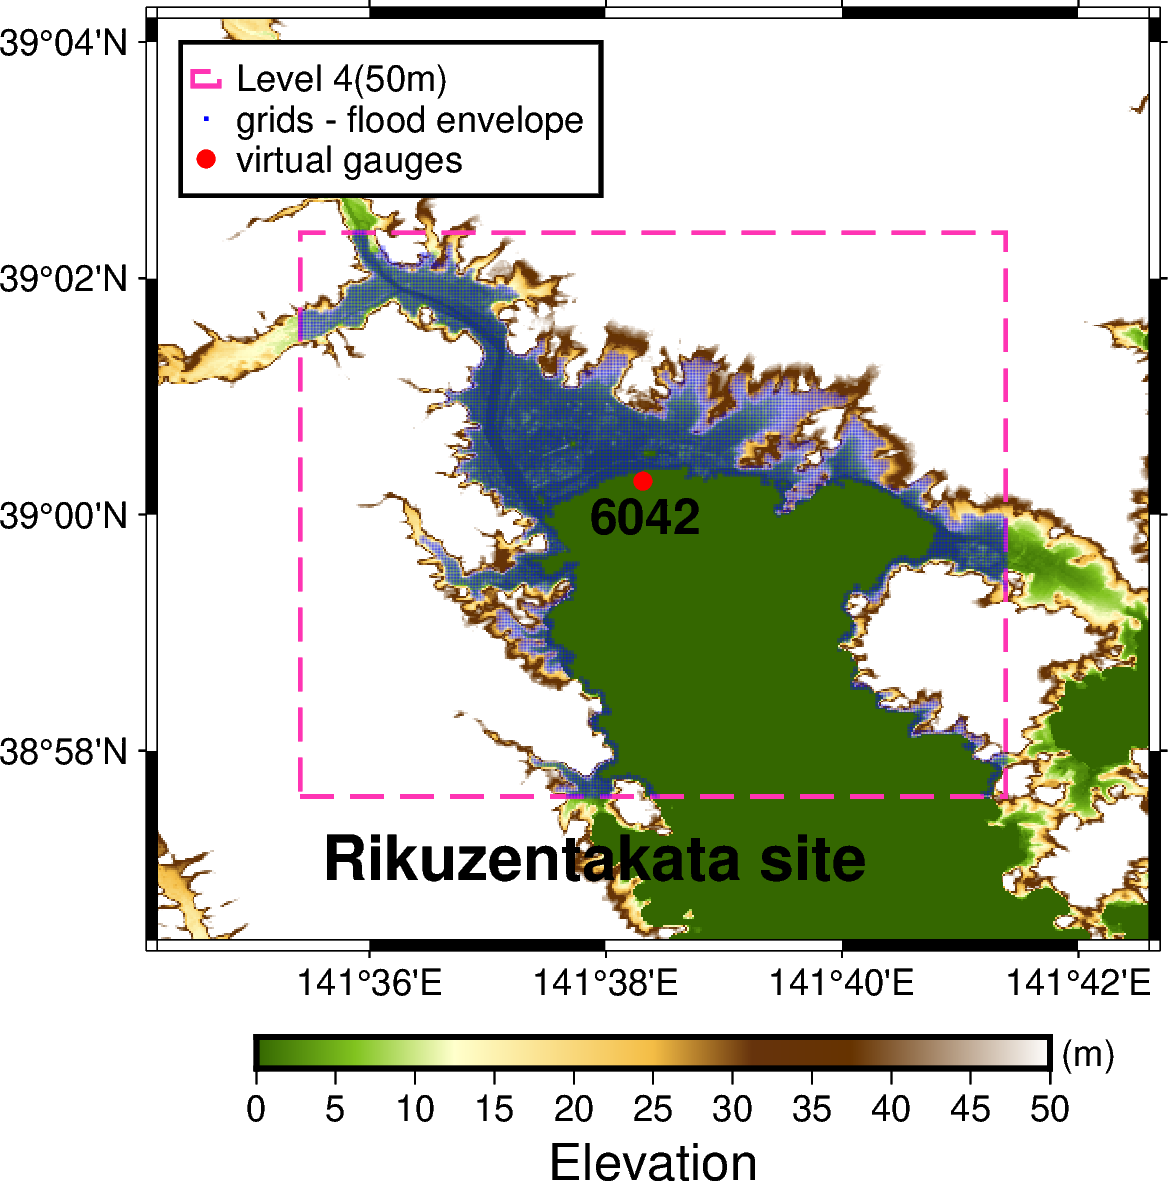

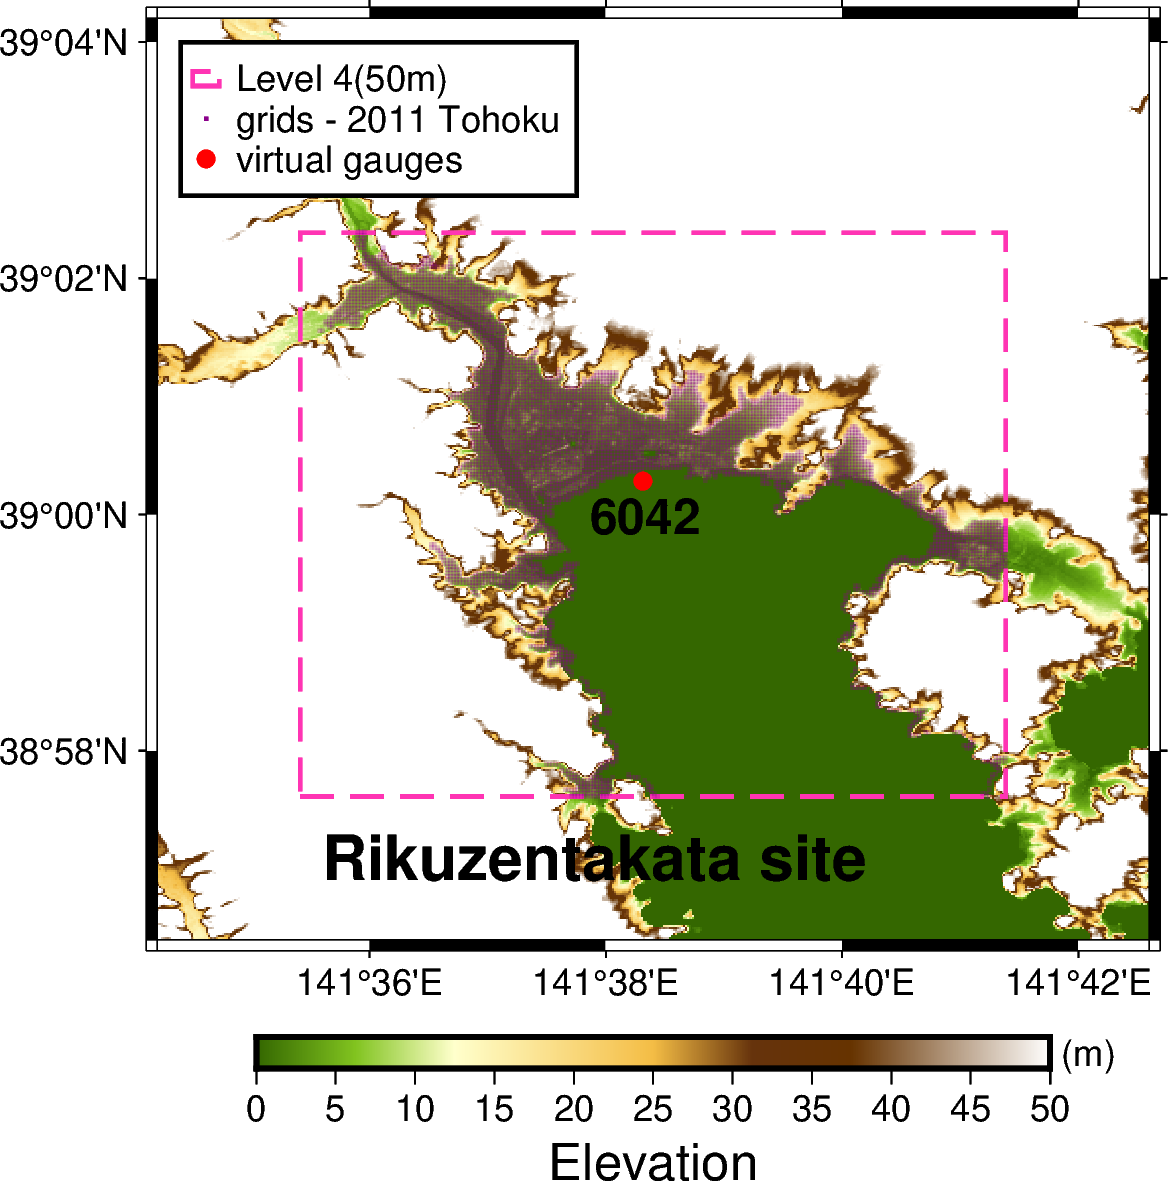

In [2]:
import geopandas as gpd
import numpy as np
import pygmt
import pandas as pd
import rioxarray

#gauge locations
gagues = gpd.read_file("/mnt/data/nragu/Tsunami/Tohoku/gis/geoclaw/gauges.gpkg")
codelist = [5832,5010,5015,5020,6042,5675,5440,5421]
sel_gauges = gagues[gagues.Code.isin(codelist)]

# Load the elevation grid from geotiff file
with rioxarray.open_rasterio(
    filename="/mnt/data/nragu/Tsunami/Tohoku/gis/topo/COP30/output_COP30.tif",
) as img:
    # Subset to area of Lāhainā in EPSG:32604 coordinates
    image = img.rio.clip_box(minx=141.5, maxx=141.8, miny=38.9, maxy=39.1)
    image = image.load()  # Force loading the DataArray into memory
grid = image[0]
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 60])

#set 0 and less as nan
# grid.values[grid.values <= 0] = np.nan

#load inundaiton data from text file
inundation = pd.read_csv("/mnt/data/nragu/Tsunami/ML_Tohoku/Paper/2copy2HPC/footprint/1GaugeRiku/_data/fgmax0003_maxatflooded.csv",
                         sep=',',header=None)

#load inundaiton data from text file
tohokugrids = pd.read_csv("/mnt/data/nragu/Tsunami/ML_Tohoku/Paper/2copy2HPC/footprint/1GaugeRiku/_data/fgmax0003_hisflooded.csv",
                         sep=',',header=None)

#add column names as lat lon elevation and max depth
inundation.columns = ['lon', 'lat', 'elevation', 'max_depth']
tohokugrids.columns = ['lon', 'lat', 'elevation','FUJI2011_42','NANKAI2022','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD',
        'SatakeMiniLowerSoft','SatakeMiniUpper','SatakeMiniUpperSoft','SatakeMiniLower' ]

#geoclaw model domain extent
domain = gpd.read_file("/mnt/data/nragu/Tsunami/Tohoku/gis/geoclaw/fine_domain.gpkg")
        # fg.x1 = 141.59 + dx050 / 2.0
        # fg.x2 = 141.69 - dx050 / 2.0
        # fg.y1 = 38.96 + dx050 / 2.0
        # fg.y2 = 39.04 - dx050 / 2.0

# #make new cpt with n intervals
pygmt.makecpt(cmap="dem1", series=[0,50,0.1])

#plot them
fig = pygmt.Figure()
fig.grdimage(grid=grid,
            projection="x60c/60c",
            frame="a",
            region = [141.57,141.71,38.94,39.07],
            # cmap=True,
)
fig.plot(data=domain, pen="1p,maroon1,-", close=True,label="Level 4(50m)")

fig.plot(
        x = inundation['lon'],
        y = inundation['lat'],
        transparency=75,
        style="s0.025c",
        pen="0.5p,blue",
        label="grids - flood envelope")

fig.plot(data= sel_gauges,
        style="c0.15c", 
        color="red", 
        pen="red", 
        label="virtual gauges")


#add annotations for gauges
for i in range(len(sel_gauges)):
    fig.text(
        x=sel_gauges['Longitude'].iloc[i],
        y=sel_gauges['Latitude'].iloc[i],
        text=sel_gauges['Code'].iloc[i],
        font="12p,Helvetica-Bold,black",
        justify="LB",
        offset="-0.45c",
    )


fig.text(
    x=141.63,    
    y=38.95,
    text="Rikuzentakata site",
    font="15p,Helvetica-Bold,black",
    justify="CM",
    offset="0.1c",
)

fig.colorbar(frame=["5", "x+lElevation", "y+l(m)"])
fig.legend(position="JTL+jTL+o0.2c", box='+gwhite+p1p')
fig.savefig("_plot/depth_processing.png")
fig.show()

#plot them with tohoku grids
fig = pygmt.Figure()
fig.grdimage(grid=grid,
            projection="x60c/60c",
            frame="a",
            region = [141.57,141.71,38.94,39.07],
            # cmap=True,
)
fig.plot(data=domain, pen="1p,maroon1,-", close=True,label="Level 4(50m)")

fig.plot(
        x = tohokugrids['lon'][tohokugrids['FUJI2011_42'] > 0.1],
        y = tohokugrids['lat'][tohokugrids['FUJI2011_42'] > 0.1],
        transparency=75,
        style="s0.025c",
        pen="0.5p,magenta4",
        label="grids - 2011 Tohoku")

fig.plot(data= sel_gauges,
        style="c0.15c", 
        color="red", 
        pen="red", 
        label="virtual gauges")


#add annotations for gauges
for i in range(len(sel_gauges)):
    fig.text(
        x=sel_gauges['Longitude'].iloc[i],
        y=sel_gauges['Latitude'].iloc[i],
        text=sel_gauges['Code'].iloc[i],
        font="12p,Helvetica-Bold,black",
        justify="LB",
        offset="-0.45c",
    )

fig.text(
    x=141.63,    
    y=38.95,
    text="Rikuzentakata site",
    font="15p,Helvetica-Bold,black",
    justify="CM",
    offset="0.1c",
)

fig.colorbar(frame=["5", "x+lElevation", "y+l(m)"])
fig.legend(position="JTL+jTL+o0.2c", box='+gwhite+p1p')
fig.savefig("_plot/Tohoku_processing.png")
fig.show()


Data summary

/home/nragu/opt/anaconda3/envs/pygmt/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/nragu/opt/anaconda3/envs/pygmt/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/nragu/opt/anaconda3/envs/pygmt/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


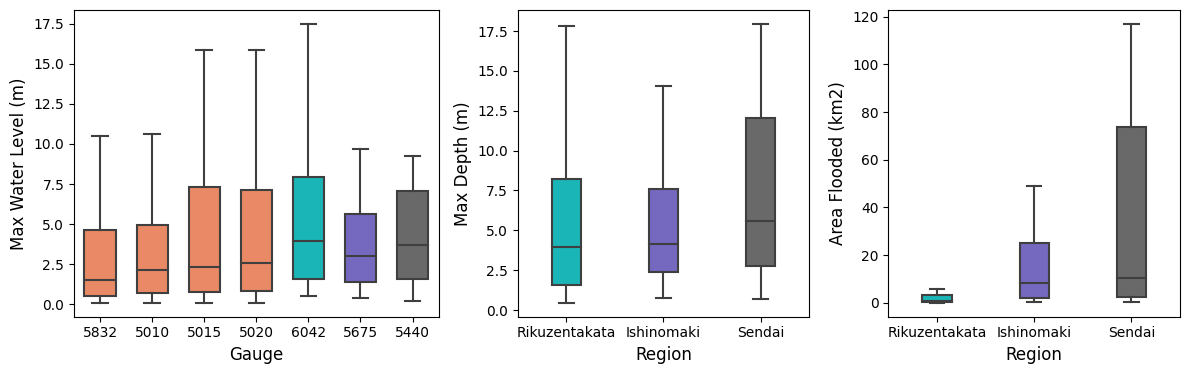

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#station to calculate stats
station_list = ['5832','5010', '5015', '5020','6042','5675','5440']
region_list = ['fgmax0003','fgmax0002','fgmax0001']
max_flood_count = {'fgmax0003':6648,'fgmax0002':54671,'fgmax0001':129941}

#area per grid of 30m x 30m = 900m2 = 0.0009km2

#create path fmt for each station
station_fmt = '/mnt/data/nragu/Tsunami/ML_Tohoku/Paper/_stats/0{}_stats.txt'
inundation_fmt = '/mnt/data/nragu/Tsunami/ML_Tohoku/Paper/_stats/{}_statatflooded.csv'

#station header
#peak value, peak time,no of peaks, even name, Mag, dz

#inundation header
#even name, max, ratio flooded 

#read station and inundation data
max_wl = pd.DataFrame()
max_depth = pd.DataFrame()
area_flooded = pd.DataFrame()

for s in station_list:
    #read files
    dat = pd.read_csv(station_fmt.format(s),sep='\s+',header=None)
    dat.columns = ['peak_value', 'peak_time', 'no_of_peaks', 'event_name', 'mag', 'dz']  
    #add station peak value to common table
    max_wl[s] = dat['peak_value']

for i, f in enumerate(region_list):
    #read files
    dat = pd.read_csv(inundation_fmt.format(f),sep=',',header=None)
    dat.columns = ['event_name', 'max_depth', 'ratio_flooded']  
    
    #add value to common tables
    area_flooded[f] = dat['ratio_flooded']*max_flood_count[f]*0.0009
    max_depth[f] = dat['max_depth']

#change column names
area_flooded.columns = ['Rikuzentakata', 'Ishinomaki', 'Sendai']
max_depth.columns = ['Rikuzentakata', 'Ishinomaki', 'Sendai']

# plot a single boxplot for max water level,
# single boxplot for max depth 
# single boxplot for area flooded

# Create a 1 by 3 grid of subplots using sns
fig, ax = plt.subplots(1, 3, figsize=(12, 4),gridspec_kw={'width_ratios': [5,4,4]})

# Flatten the 1 by 3 grid into a 1D array for easier iteration
ax = ax.flatten()

my_colors1 = {
            '5832': 'coral',
            '6042': 'darkturquoise',
            '5675': 'slateblue',
            '5440': 'dimgrey',
            '5010': 'coral',
            '5015': 'coral',
            '5020': 'coral',
            
            }

my_colors2 = {'Rikuzentakata': 'darkturquoise', 'Ishinomaki': 'slateblue', 'Sendai': 'dimgrey'}

#use same width for all plots

#plot max water level
sns.boxplot(data=max_wl, ax=ax[0], orient='v', palette=my_colors1, showfliers=False, width=0.6)
ax[0].set_ylabel('Max Water Level (m)', fontsize=12)
ax[0].set_xlabel('Gauge', fontsize=12)

#plot max depth
sns.boxplot(data=max_depth, ax=ax[1], orient='v', palette=my_colors2, showfliers=False, width=0.3)
ax[1].set_ylabel('Max Depth (m)', fontsize=12)
ax[1].set_xlabel('Region', fontsize=12)

#plot area flooded
sns.boxplot(data=area_flooded, ax=ax[2], orient='v', palette=my_colors2, showfliers=False, width=0.3)
ax[2].set_ylabel('Area Flooded (km2)', fontsize=12)
ax[2].set_xlabel('Region', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('/mnt/data/nragu/Tsunami/ML_Tohoku/Paper/_plot/data_stats.png', dpi=600)

# Show the plot
plt.show()  


In [11]:
sns.color_palette("Paired")[2]


(0.6980392156862745, 0.8745098039215686, 0.5411764705882353)

Check model parameters and size

In [2]:
from torchsummary import summary
import model_utils as utils
import torch
model = torch.load(f"/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/SR/out/model_coupled_off[64, 128, 256]_on[64, 64]_epoch_1000_900.pt",map_location=torch.device('cpu'))
model.eval()
# summary(model,[(5,480),(186181,)])
summary(model,[(5,480),(186181,)])

ModuleNotFoundError: No module named 'torchsummary'